In [1]:
import sys, os, re, math
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold

import matplotlib.pyplot as plt
import seaborn as sns

print("Python exe:", sys.executable)
print("Working dir:", os.getcwd())

Python exe: d:\DA_Final_Tox21\Final_DA.conda_envs\drug_discovery\python.exe
Working dir: d:\DA_Final_Tox21


In [2]:
# Load Tox21 (DeepChem) dataset
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_tox21(
    featurizer='Raw',
    splitter=None
)

# datasets chỉ có 1 phần tử: full dataset
full_dc = datasets[0]

print("Number of tasks/endpoints:", len(tasks))
print("Tasks:", tasks)
print("Total samples:", len(full_dc))

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
d:\DA_Final_Tox21\Final_DA.conda_envs\drug_discovery\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch

Number of tasks/endpoints: 12
Tasks: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
Total samples: 7823


### **Convert DeepChem → DataFrame**

In [3]:
# DeepChem Dataset to dataframe
X_smiles = full_dc.ids        # SMILES
Y = full_dc.y                 # shape (N, num_tasks)
W = full_dc.w                 # mask for missing labels

df = pd.DataFrame({"smiles": X_smiles})

# add each endpoint label and mask
for j, t in enumerate(tasks):
    df[t] = Y[:, j]
    df[f"{t}_w"] = W[:, j]

print("df shape:", df.shape)
df.head()


df shape: (7823, 25)


,smiles,NR-AR,NR-AR_w,NR-AR-LBD,NR-AR-LBD_w,NR-AhR,NR-AhR_w,NR-Aromatase,NR-Aromatase_w,NR-ER,...,SR-ARE,SR-ARE_w,SR-ATAD5,SR-ATAD5_w,SR-HSE,SR-HSE_w,SR-MMP,SR-MMP_w,SR-p53,SR-p53_w
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,1.044317,0.0,1.036383,1.0,8.518229,0.0,0.000000,0.0,...,1.0,6.183652,0.0,1.038818,0.0,1.061104,0.0,1.187884,0.0,1.066677
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,1.044317,0.0,1.036383,0.0,1.133010,0.0,1.054397,0.0,...,0.0,0.000000,0.0,1.038818,0.0,0.000000,0.0,1.187884,0.0,1.066677
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,1.192914,0.0,0.000000,0.0,1.061104,0.0,0.000000,0.0,0.000000
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,1.044317,0.0,1.036383,0.0,1.133010,0.0,1.054397,0.0,...,0.0,0.000000,0.0,1.038818,0.0,0.000000,0.0,1.187884,0.0,1.066677
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,1.044317,0.0,1.036383,0.0,1.133010,0.0,1.054397,0.0,...,0.0,1.192914,0.0,1.038818,0.0,1.061104,0.0,1.187884,0.0,1.066677


### **Kiểm tra SMILES (valid/invalid) + loại invalid**

In [4]:
def is_valid_smiles(s):
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return False
    mol = Chem.MolFromSmiles(str(s))
    return mol is not None

df["is_valid"] = df["smiles"].apply(is_valid_smiles)

print("Total:", len(df))
print("Valid:", df["is_valid"].sum())
print("Invalid:", (~df["is_valid"]).sum())

df = df[df["is_valid"]].drop(columns=["is_valid"]).reset_index(drop=True)
print("After removing invalid:", len(df))

[23:49:29] WARNING: not removing hydrogen atom without neighbors


Total: 7823
Valid: 7823
Invalid: 0
After removing invalid: 7823


### **Canonicalize SMILES + remove duplicates**

In [5]:
def canonicalize_smiles(s):
    mol = Chem.MolFromSmiles(str(s))
    return Chem.MolToSmiles(mol, canonical=True) if mol is not None else None

df["smiles_canon"] = df["smiles"].apply(canonicalize_smiles)

before = len(df)
df = df.dropna(subset=["smiles_canon"]).drop_duplicates(subset=["smiles_canon"]).reset_index(drop=True)
after = len(df)

print("Before dedup:", before)
print("After dedup :", after)

# dùng smiles_canon làm SMILES chính
df = df.drop(columns=["smiles"]).rename(columns={"smiles_canon": "smiles"})
df.head()

[23:51:17] WARNING: not removing hydrogen atom without neighbors


Before dedup: 7823
After dedup : 7823


,NR-AR,NR-AR_w,NR-AR-LBD,NR-AR-LBD_w,NR-AhR,NR-AhR_w,NR-Aromatase,NR-Aromatase_w,NR-ER,NR-ER_w,...,SR-ARE_w,SR-ATAD5,SR-ATAD5_w,SR-HSE,SR-HSE_w,SR-MMP,SR-MMP_w,SR-p53,SR-p53_w,smiles
0,0.0,1.044317,0.0,1.036383,1.0,8.518229,0.0,0.000000,0.0,0.000000,...,6.183652,0.0,1.038818,0.0,1.061104,0.0,1.187884,0.0,1.066677,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,1.044317,0.0,1.036383,0.0,1.133010,0.0,1.054397,0.0,1.146617,...,0.000000,0.0,1.038818,0.0,0.000000,0.0,1.187884,0.0,1.066677,CCN1C(=O)NC(c2ccccc2)C1=O
2,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,1.192914,0.0,0.000000,0.0,1.061104,0.0,0.000000,0.0,0.000000,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,1.044317,0.0,1.036383,0.0,1.133010,0.0,1.054397,0.0,1.146617,...,0.000000,0.0,1.038818,0.0,0.000000,0.0,1.187884,0.0,1.066677,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,1.044317,0.0,1.036383,0.0,1.133010,0.0,1.054397,0.0,1.146617,...,1.192914,0.0,1.038818,0.0,1.061104,0.0,1.187884,0.0,1.066677,CC(O)(P(=O)(O)O)P(=O)(O)O


### **EDA missing labels theo từng endpoint**

In [6]:
endpoint_stats = []
for t in tasks:
    w = df[f"{t}_w"].values
    y = df[t].values
    
    n_total = len(df)
    n_labeled = int((w > 0).sum())
    n_missing = n_total - n_labeled
    
    # positive rate trên phần có label
    if n_labeled > 0:
        pos = int(((y == 1) & (w > 0)).sum())
        neg = int(((y == 0) & (w > 0)).sum())
        pos_rate = pos / n_labeled
    else:
        pos = neg = 0
        pos_rate = np.nan
    
    endpoint_stats.append([t, n_labeled, n_missing, pos, neg, pos_rate])

# Biểu diễn thống kê các endpoint
stats_df = pd.DataFrame(endpoint_stats, columns=["endpoint", "labeled", "missing", "pos", "neg", "pos_rate"])
stats_df = stats_df.sort_values("pos_rate", ascending=False).reset_index(drop=True)
stats_df

,endpoint,labeled,missing,pos,neg,pos_rate
0,SR-ARE,5825,1998,942,4883,0.161717
1,SR-MMP,5804,2019,918,4886,0.158167
2,NR-ER,6186,1637,791,5395,0.127869
3,NR-AhR,6542,1281,768,5774,0.117395
4,SR-p53,6767,1056,423,6344,0.062509
5,SR-HSE,6460,1363,372,6088,0.057585
6,NR-Aromatase,5815,2008,300,5515,0.051591
7,NR-ER-LBD,6948,875,349,6599,0.050230
8,NR-AR,7258,565,308,6950,0.042436
9,SR-ATAD5,7065,758,264,6801,0.037367


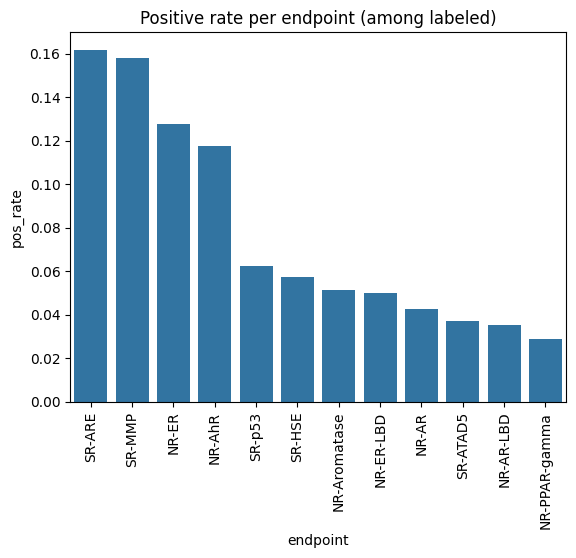

In [7]:
plt.figure()
sns.barplot(data=stats_df, x="endpoint", y="pos_rate")
plt.xticks(rotation=90)
plt.title("Positive rate per endpoint (among labeled)")
plt.show()